In [1]:
import numpy as np
import pandas as pd

In [2]:
import os 
import sys
sys.path.append(os.path.abspath('../common')) # add path to common functions

In [3]:
from preprocess import getdfs

train_df, valid_df = getdfs(data = 'text_seq', train_size = 1)

In [4]:
train_df.head()

,input_str,label
0,0000154364642718159661428002624223132284159626...,0
1,0004641596369515436422262614110471596262476161...,0
2,0001543626215965999614422464135806142624051159...,0
3,0000154364224641238614262159689561596284351061...,1
4,0004641899422154362069015966142624761262159661...,1


In [5]:
train_df['input_str'] = train_df['input_str'].apply(lambda x : x[3:])
valid_df['input_str'] = valid_df['input_str'].apply(lambda x : x[3:])

In [6]:
def insert_spaces(string):
  """Inserts spaces between all two characters in a string.
  Args:
    string: The input string.

  Returns:
    The string with spaces inserted between all two characters.
  """

  result = ""
  for i in range(len(string)):
    result += string[i]
    if i < len(string) - 1:
      result += " "
  return result


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer='char')

# Fit and transform the data
x_train = vectorizer.fit_transform(train_df["input_str"])
x_valid = vectorizer.transform(valid_df["input_str"])
y_train = train_df["label"]
y_valid = valid_df["label"]

In [20]:
x_train = x_train.toarray()
x_valid = x_valid.toarray()

In [124]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Define the DNN model
def create_model(lr=0.001):
    model = models.Sequential()
    
    # Input layer (10 input features)
    model.add(layers.InputLayer(shape=(10,)))
    
    # Hidden layers
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # First hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # Second hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # Second hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    
    # Output layer
    # Assuming binary classification; adjust output neurons and activation for multi-class or regression
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class, 'mse' for regression
                  metrics=['accuracy'])
    
    return model

In [133]:
model = create_model(lr = 0.001)

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

In [135]:
# Train the model
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), 
                    epochs=30,  # Set your number of epochs
                    batch_size=64)  # Set an appropriate batch size

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5086 - loss: 1.1822 - val_accuracy: 0.4826 - val_loss: 1.0619
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 1.1037 - val_accuracy: 0.4683 - val_loss: 1.0351
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5090 - loss: 1.0543 - val_accuracy: 0.4233 - val_loss: 1.0112
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5041 - loss: 1.0165 - val_accuracy: 0.4376 - val_loss: 0.9855
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5135 - loss: 0.9807 - val_accuracy: 0.4499 - val_loss: 0.9603
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 0.9559 - val_accuracy: 0.4724 - val_loss: 0.9348
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 0.9304 - val_accuracy: 0.4294 - val_loss: 0.9122
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5045 - loss: 0.9051 - val_accuracy: 0.

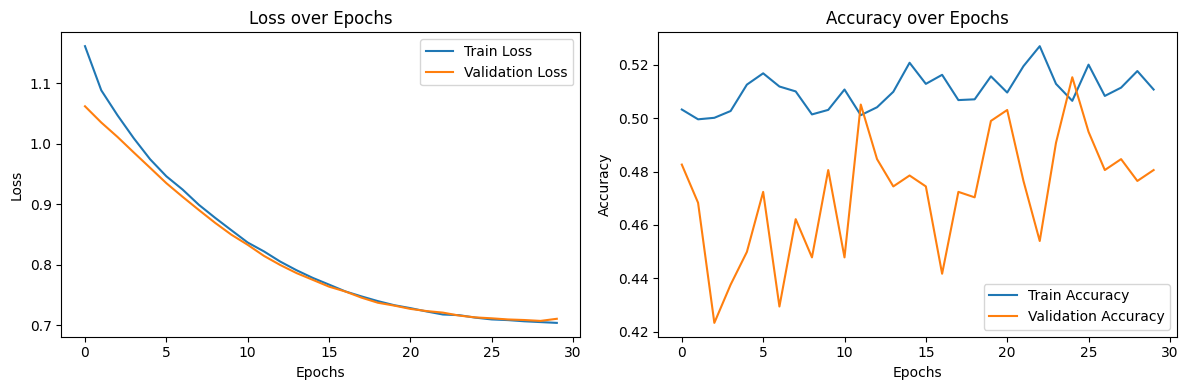

In [136]:
from evaluate import plot_history, evaluate_predictions

plot_history(history)

In [137]:
y_pred = model.predict(x_valid)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [138]:
y_pred = y_pred > 0.5
np.unique(y_pred, return_counts=True)

(array([False,  True]), array([346, 143]))

==========DNN==========
              precision    recall  f1-score   support

     Class 0       0.50      0.68      0.58       252
     Class 1       0.44      0.27      0.33       237

    accuracy                           0.48       489
   macro avg       0.47      0.47      0.45       489
weighted avg       0.47      0.48      0.46       489

Accuracy is 0.48057259713701433
==========DNN==========


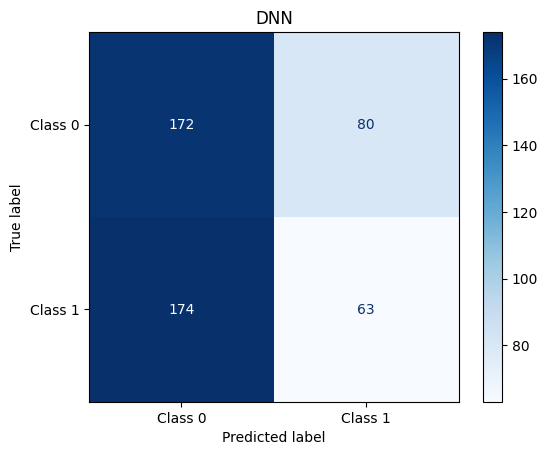

In [140]:
evaluate_predictions(y_valid, y_pred, "DNN")

In [141]:
model.predict(x_valid)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[0.4853034 ],
       [0.47202557],
       [0.46379128],
       [0.47330797],
       [0.46377695],
       [0.45197323],
       [0.45957756],
       [0.47623533],
       [0.49384505],
       [0.4650879 ],
       [0.47193763],
       [0.47947064],
       [0.4864431 ],
       [0.48403397],
       [0.46592572],
       [0.48564783],
       [0.45596033],
       [0.4591656 ],
       [0.48503426],
       [0.49881715],
       [0.4740309 ],
       [0.47428045],
       [0.47490427],
       [0.47650638],
       [0.5300699 ],
       [0.463509  ],
       [0.5705865 ],
       [0.53438634],
       [0.47184488],
       [0.47220832],
       [0.60027707],
       [0.48322135],
       [0.50341845],
       [0.4621225 ],
       [0.47170982],
       [0.46528265],
       [0.53844094],
       [0.5554308 ],
       [0.47183332],
       [0.49866343],
       [0.46748385],
       [0.5406006 ],
       [0.47157365],
       [0.4476633 ],
       [0.48493144],
       [0.4556827 ],
       [0.48973772],
       [0.460